# Strategic Bidding Analysis (Case: 5bus_nrel)

In this analysis, we want to study an effective structure for PQ-Curves that helps us build optimal bidding strategies in electricity markets.

## Dependencies and Data Preparation

#### Packages and Diretory

In [1]:
#make sure it is in "GridAnalysis.jl" cd("C:/Users/Daniele/Desktop/Projeto/GridAnalysis.jl")

In [2]:
pwd()

"C:\\Users\\Daniele\\Desktop\\Projeto\\GridAnalysis.jl"

In [3]:
using Pkg
Pkg.activate("./examples/5bus_nrel/bid_analysis_5bus_nrel")

In [4]:
Pkg.instantiate()

In [5]:
using Logging 
Logging.disable_logging(Logging.Info) #script to disable info messages 
Logging.disable_logging(Logging.Warn) #script to disable warning messages

LogLevel(1001)

In [6]:
using Dates
using DataFrames
using GridAnalysis
using Gurobi
using PowerSystems
using PowerSimulations
using Test
using Measures
using Plots

#### Uploading Utils

Might not work if running lines manually 
(solution: edit to be the path for this examples directory for example: 'example_dir = "./examples/5bus_nrel/"')

In [7]:
example_dir = "./examples/5bus_nrel/"
data_dir = joinpath(example_dir, "data")
include(joinpath(example_dir, "utils.jl"))

load_plot_set_of_simulations

#### Data Prep and Build Market Simulator
define solvers for Unit Commitment (UC), Real Time (RT) and Economic Dispatch (ED)

In [8]:
solver_uc = optimizer_with_attributes(Gurobi.Optimizer)
solver_rt = optimizer_with_attributes(Gurobi.Optimizer)
solver_ed = optimizer_with_attributes(Gurobi.Optimizer)

MathOptInterface.OptimizerWithAttributes(Gurobi.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[])

## Define analysis to be done

In [9]:
#=Network = [DCPPowerModel, NFAPowerModel, CopperPlatePowerModel];
Ramp = [true,false]; 
Minimal_generation = [true,false]; 
Reserve = [true,false]; 
Offer_Bus = ["bus3","bus5"]; # ["bus1", "bus2", "bus3", "bus4", "bus5"];
bidding_period = [collect(1:24)];
=#

#### Create a DataFrame where each line represents one analysis 

In [10]:
df = DataFrame(Network = [], 
               Ramp = [],
               Minimal_generation = [],
               Reserve = [],
               Offer_Bus = [],
               bidding_period = []) 
new_data = DataFrame(Network = [Dict("DA"=>DCPPowerModel, "RT"=>DCPPowerModel),Dict("DA"=>NFAPowerModel, "RT"=>DCPPowerModel),Dict("DA"=>NFAPowerModel, "RT"=>NFAPowerModel),Dict("DA"=>CopperPlatePowerModel, "RT"=>DCPPowerModel),Dict("DA"=>CopperPlatePowerModel, "RT"=>CopperPlatePowerModel)],
Ramp = [Dict("DA"=>true, "RT"=>true),Dict("DA"=>true, "RT"=>true),Dict("DA"=>true, "RT"=>true),Dict("DA"=>true, "RT"=>true),Dict("DA"=>true, "RT"=>true)],
Minimal_generation = [Dict("DA"=>true, "RT"=>true),Dict("DA"=>true, "RT"=>true),Dict("DA"=>true, "RT"=>true),Dict("DA"=>true,
            "RT"=>true),Dict("DA"=>true, "RT"=>true)],
Reserve = [true,true,true,true,true],
Offer_Bus = ["bus5","bus5","bus5","bus5","bus5"],
bidding_period = [collect(1:24),collect(1:24),collect(1:24),collect(1:24),collect(1:24)])
append!(df, new_data)

new_data_2 = DataFrame(Network = [Dict("DA"=>DCPPowerModel, "RT"=>DCPPowerModel),Dict("DA"=>DCPPowerModel, "RT"=>DCPPowerModel)],
Ramp = [Dict("DA"=>false, "RT"=>true),Dict("DA"=>false, "RT"=>false)],
Minimal_generation = [Dict("DA"=>false, "RT"=>true),Dict("DA"=>false, "RT"=>false)],
Reserve = [true,true],
Offer_Bus = ["bus5","bus5"],
bidding_period = [collect(1:24),collect(1:24)])
append!(df, new_data_2)

new_data_3 = DataFrame(Network = [Dict("DA"=>DCPPowerModel, "RT"=>DCPPowerModel)],
Ramp = [Dict("DA"=>true, "RT"=>true)],
Minimal_generation = [Dict("DA"=>true, "RT"=>true)],
Reserve = [false],
Offer_Bus = ["bus5"],
bidding_period = [collect(1:24)])
append!(df, new_data_3)

df[!,1:6]

,Network,Ramp
,Any,Any
1,"Dict(""RT""=>DCPPowerModel, ""DA""=>DCPPowerModel)","Dict(""RT""=>1, ""DA""=>1)"
2,"Dict(""RT""=>DCPPowerModel, ""DA""=>NFAPowerModel)","Dict(""RT""=>1, ""DA""=>1)"
3,"Dict(""RT""=>NFAPowerModel, ""DA""=>NFAPowerModel)","Dict(""RT""=>1, ""DA""=>1)"
4,"Dict(""RT""=>DCPPowerModel, ""DA""=>CopperPlatePowerModel)","Dict(""RT""=>1, ""DA""=>1)"
5,"Dict(""RT""=>CopperPlatePowerModel, ""DA""=>CopperPlatePowerModel)","Dict(""RT""=>1, ""DA""=>1)"
6,"Dict(""RT""=>DCPPowerModel, ""DA""=>DCPPowerModel)","Dict(""RT""=>1, ""DA""=>0)"
7,"Dict(""RT""=>DCPPowerModel, ""DA""=>DCPPowerModel)","Dict(""RT""=>0, ""DA""=>0)"
8,"Dict(""RT""=>DCPPowerModel, ""DA""=>DCPPowerModel)","Dict(""RT""=>1, ""DA""=>1)"


#### Define range quota and period to be analysed

In [11]:
range_quota = Float64.(collect(0:0.1:4));
initial_time = Date("2020-01-01");
period_analysed = [5,19];
initial_bidding_time = DateTime("2020-01-01");
path = "results";

## Run & Load all the simulations

In [13]:
run_set_of_simulations(df, data_dir, example_dir, solver_uc, solver_ed, solver_rt,
    range_quota, initial_time, initial_bidding_time, path)

In [44]:
lines=[1,2,3,4,5,6,7,8]
period_analysed=[[5],[19]] 

2-element Vector{Vector{Int64}}:
 [5]
 [19]

In [47]:
lmps[4][0.0]

Dict{String, DataFrame} with 2 entries:
  "RT" => 288×2 DataFrame…
  "DA" => 24×6 DataFrame…

In [13]:
lmps, results = load_set_of_simulations(df, data_dir, example_dir, solver_uc, solver_ed, solver_rt,
        range_quota, lines, initial_bidding_time, path)

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


(Any[Dict{Any, Any}(1.7 => Dict{String, DataFrame}("RT" => 288×6 DataFrame
 Row │ DateTime             bus4         bus2          bus5      bus3          ⋯
     │ DateTime             Float64      Float64       Float64   Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2020-01-01T00:00:00  5425.21      10000.0       0.833333  8073.77       ⋯
   2 │ 2020-01-01T00:05:00  5425.21      10000.0       0.833333  8073.77
   3 │ 2020-01-01T00:10:00  5425.21      10000.0       0.833333  8073.77
   4 │ 2020-01-01T00:15:00  5425.21      10000.0       0.833333  8073.77
   5 │ 2020-01-01T00:20:00     2.51417       1.9109    0.833333     2.16491    ⋯
   6 │ 2020-01-01T00:25:00     2.51417       1.9109    0.833333     2.16491
   7 │ 2020-01-01T00:30:00     2.51417       1.9109    0.833333     2.16491
   8 │ 2020-01-01T00:35:00     2.51417       1.9109    0.833333     2.16491
   9 │ 2020-01-01T00:40:00     2.51417       1.9109    0.833333     2.164

### Generate graphics 

#### Generation stack virtual

In [14]:
graphic="plot_generation_stack_virtual"
plt_g=load_plot_set_of_simulations(
    df, 
    data_dir, 
    example_dir, 
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
)

#=
global plt_g=Array{Any}(nothing, length(lines), length(period_analysed),2)

for (x,l) in enumerate(lines)
    for (y,t) in enumerate(period_analysed)
        global plt_g[x,y,1] = plot_generation_stack_virtual(sys_uc, results_df; type="DA", period=period_analysed[y], initial_time, xtickfontsize=8, margin=8mm, size=(800, 600),)
        global plt_g[x,y,2] = plot_generation_stack_virtual(sys_rt, results_df; type="RT", period=period_analysed[y], initial_time, xtickfontsize=8, margin=8mm, size=(800, 600),)
    end
end
=#



        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


8×2×2 Array{Any, 3}:
[:, :, 1] =
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}
 Plot{Plots.GRBackend() n=6}  Plot{Plots.GRBackend() n=6}

[:, :, 2] =
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}  Plot{Plots.GRBackend() n=5}

#### Revenue curves (renewable plus virtual)

In [45]:
graphic="plot_revenue_curves_renewable_plus_virtual"
plt_rv=load_plot_set_of_simulations(
    df, 
    data_dir, 
    example_dir, 
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
)
#=
global plt_rv=Array{Any}(nothing, length(lines))

for (x,l) in enumerate(lines) 
    global plt_rv[x] = plot_revenue_curves_renewable_plus_virtual(market_simulator, lmps_df, results_df,
        [0.0, 1.0, 2.0],"WindBusA", df.Offer_Bus[l]*"_virtual_supply")
end
=#

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


LoadError: ArgumentError: column name :lmp not found in the data frame

#### Price curves

In [16]:
graphic="plot_price_curves"
plt_p=load_plot_set_of_simulations(
    df, 
    data_dir, 
    example_dir, 
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
)
#=
global plt_p=Array{Any}(nothing, length(lines), length(period_analysed))

for (x,l) in enumerate(lines)
    for (y,t) in enumerate(period_analysed)
        global plt_p[x,y] = plot_price_curves(lmps[x], period_analysed[y], unique(df.Offer_Bus), df.Offer_Bus[l], initial_time)
    end
end
=#

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


8×2 Matrix{Any}:
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}  Plot{Plots.GRBackend() n=2}

#### Virtual revenue curves

In [17]:
graphic="plot_revenue_curves"
plt_r=load_plot_set_of_simulations(
    df, 
    data_dir, 
    example_dir, 
    solver_uc, 
    solver_ed, 
    solver_rt, 
    range_quota, 
    initial_time,
    lines,
    period_analysed,
    initial_bidding_time,
    path,
    graphic,
)
#=
global plt_r=Array{Any}(nothing, length(lines))
global period = [period_analysed[i][1] for i=1:length(period_analysed)]
for (x,l) in enumerate(lines)
    global plt_r[x] = plot_revenue_curves(market_simulator, lmps[x], results[x], period,
        df.Offer_Bus[l]*"_virtual_supply", initial_time)
end
=#

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


8-element Vector{Any}:
 Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}
 Plot{Plots.GRBackend() n=2}

## Network analysis

### CASE1: DC - DC

In [18]:
df[1,:]

,Network,Ramp,Minimal_generation
,Any,Any,Any
1,"Dict(""RT""=>DCPPowerModel, ""DA""=>DCPPowerModel)","Dict(""RT""=>1, ""DA""=>1)","Dict(""RT""=>1, ""DA""=>1)"


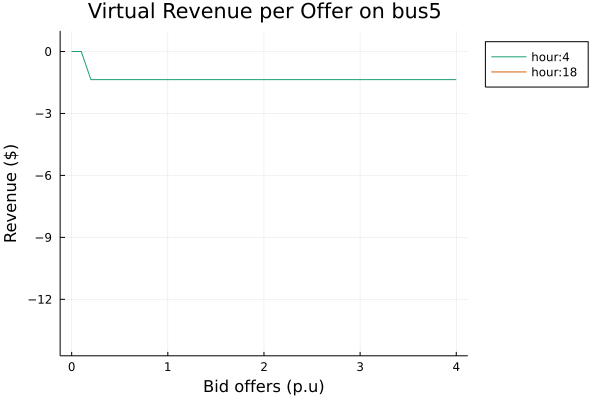

In [19]:
plt_r[1]

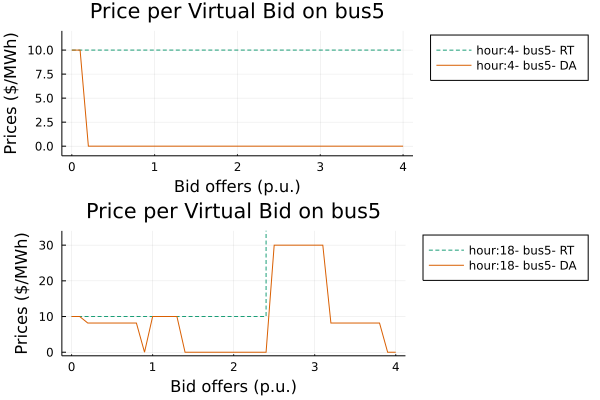

In [23]:
plot(plt_p[1,1],plt_p[1,2],layout=(2,1)) 

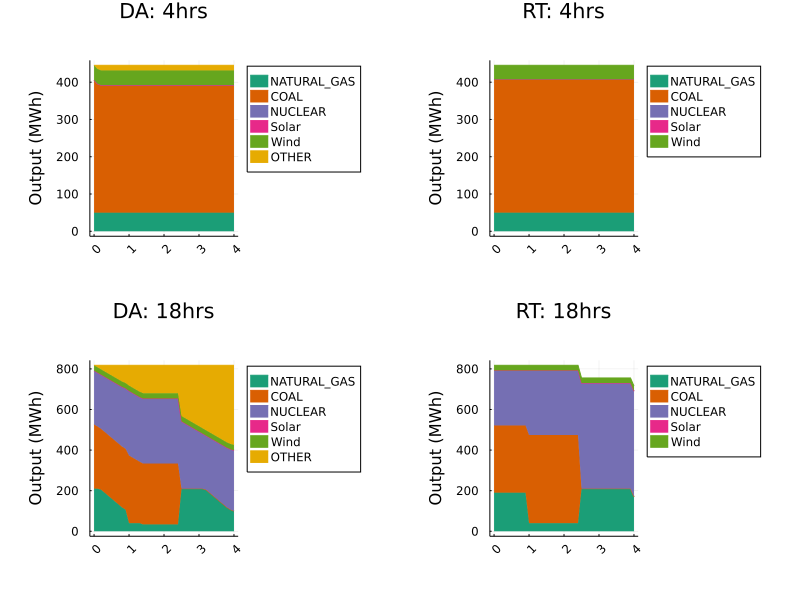

In [24]:
plot(plt_g[1,1,1], plt_g[1,1,2],plt_g[1,2,1], plt_g[1,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [ ]:
#TODO: add commit

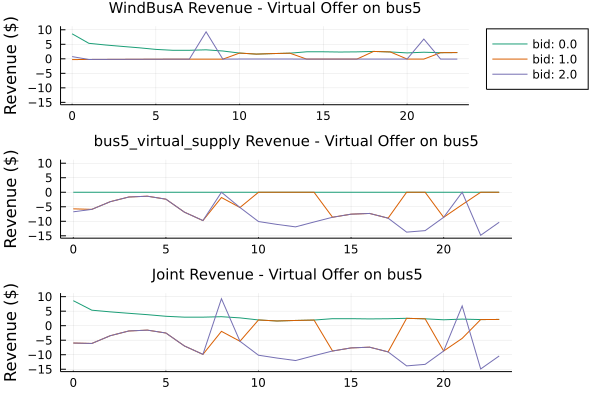

In [27]:
plt_rv[1]  #notebook separado (deixa no final por enquanto)

### CASE2: DC - NFA

In [28]:
df[2,:]

,Network,Ramp,Minimal_generation
,Any,Any,Any
2,"Dict(""RT""=>DCPPowerModel, ""DA""=>NFAPowerModel)","Dict(""RT""=>1, ""DA""=>1)","Dict(""RT""=>1, ""DA""=>1)"


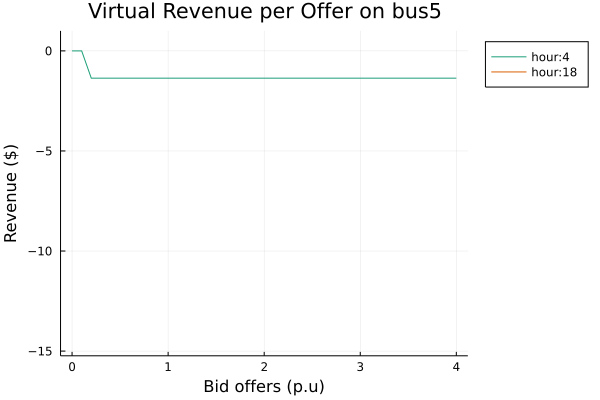

In [30]:
plt_r[2]

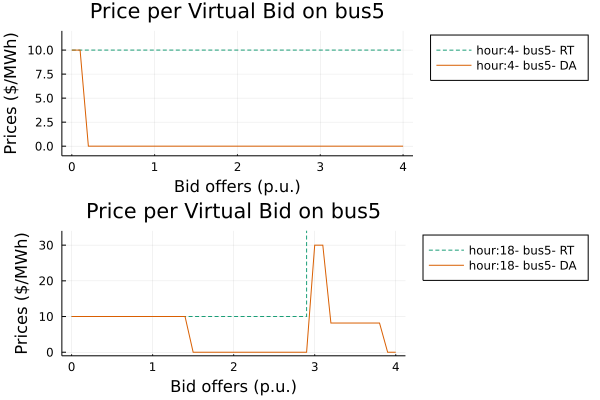

In [29]:
plot(plt_p[2,1],plt_p[2,2],layout=(2,1)) 

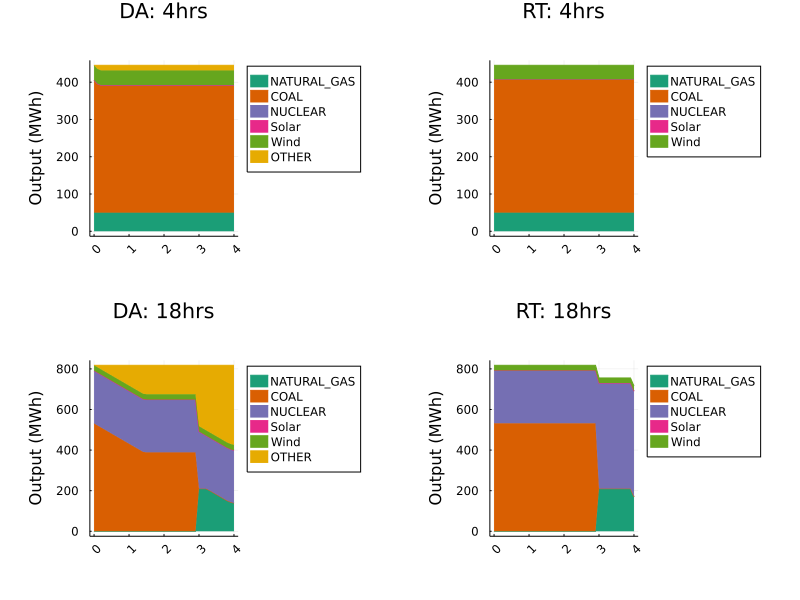

In [31]:
plot(plt_g[2,1,1], plt_g[2,1,2],plt_g[2,2,1], plt_g[2,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [ ]:
#TODO: add commit

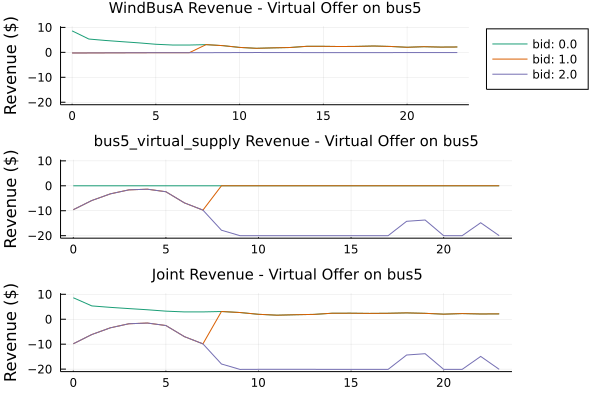

In [35]:
plt_rv[2]

### CASE3: NFA - NFA

In [41]:
df[3,:]

,Network,Ramp,Minimal_generation
,Any,Any,Any
3,"Dict(""RT""=>NFAPowerModel, ""DA""=>NFAPowerModel)","Dict(""RT""=>1, ""DA""=>1)","Dict(""RT""=>1, ""DA""=>1)"


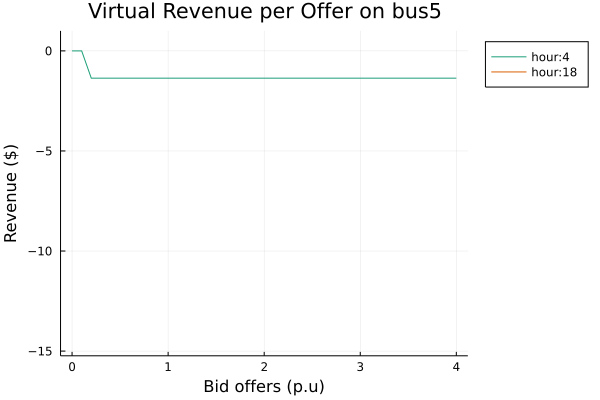

In [37]:
plt_r[3]

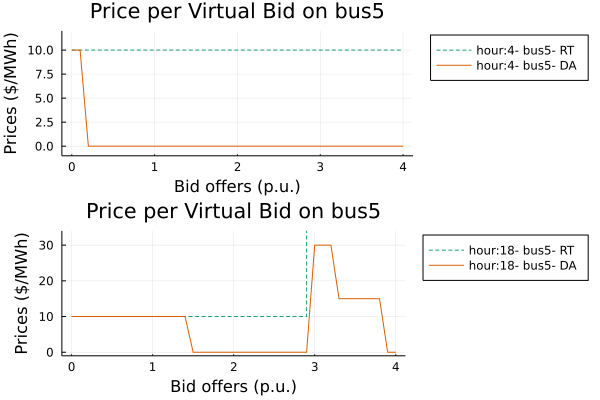

In [43]:
plot(plt_p[3,1],plt_p[3,2],layout=(2,1)) 

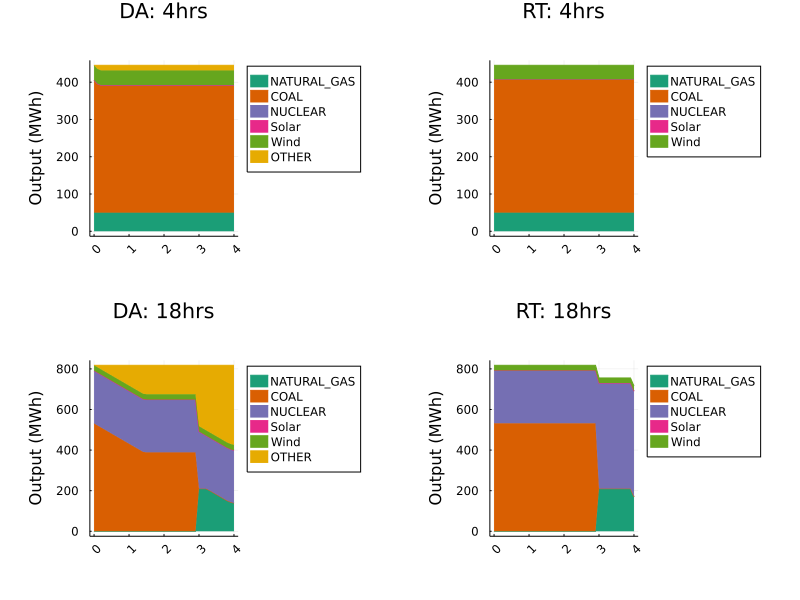

In [38]:
plot(plt_g[3,1,1], plt_g[3,1,2],plt_g[3,2,1], plt_g[3,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [39]:
#add commit

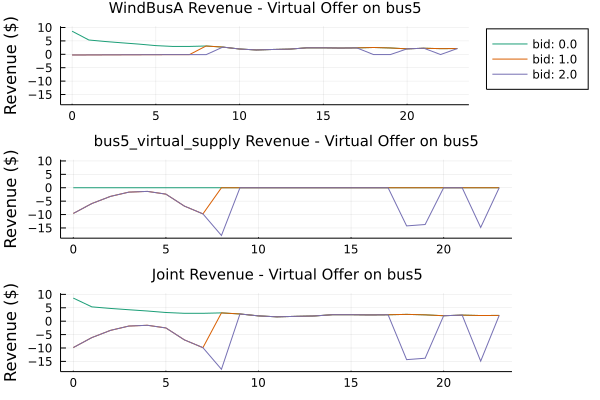

In [40]:
plt_rv[3]

### CASE4: DC - CopperPlate

In [42]:
df[4,:]

,Network,Ramp
,Any,Any
4,"Dict(""RT""=>DCPPowerModel, ""DA""=>CopperPlatePowerModel)","Dict(""RT""=>1, ""DA""=>1)"


In [ ]:
plt_r[4]

In [ ]:
plot(plt_p[4,1],plt_p[4,2],layout=(2,1)) 

In [ ]:
plot(plt_g[4,1,1], plt_g[4,1,2],plt_g[4,2,1], plt_g[4,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [ ]:
#add commit

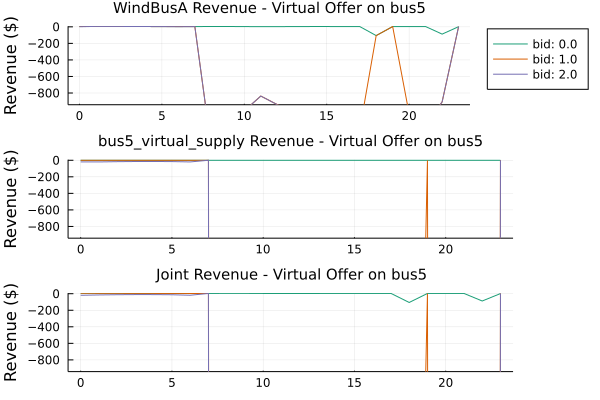

In [31]:
plt_rv[4]

### CASE5: CopperPlate - CopperPlate

In [ ]:
df[5,:]

In [ ]:
plt_r[5]

In [ ]:
plot(plt_p[5,1],plt_p[5,2],layout=(2,1)) 

In [ ]:
plot(plt_g[5,1,1], plt_g[5,1,2],plt_g[5,2,1], plt_g[5,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [ ]:
#add commit

In [ ]:
plt_rv[5]

##  System capacities analysis

### CASE6: Ramp & Minimal generation false - Ramp & Minimal generation true

In [ ]:
df[6,:]

In [ ]:
plt_r[6]

In [ ]:
plot(plt_p[6,1],plt_p[6,2],layout=(2,1)) 

In [ ]:
plot(plt_g[6,1,1], plt_g[6,1,2],plt_g[6,2,1], plt_g[6,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [ ]:
#add commit

In [ ]:
plt_rv[6]

### CASE7:  Ramp & Minimal generation false - Ramp & Minimal generation false

In [ ]:
df[7,:]

In [ ]:
plt_r[7]

In [ ]:
plot(plt_p[7,1],plt_p[7,2],layout=(2,1)) 

In [ ]:
plot(plt_g[7,1,1], plt_g[7,1,2],plt_g[7,2,1], plt_g[7,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [ ]:
#add commit

In [ ]:
plt_rv[7]

## Market analysis

### CASE8: Reserve false

In [ ]:
df[8,:]

In [ ]:
plt_r[8]

In [ ]:
plot(plt_p[8,1],plt_p[8,2],layout=(2,1)) 

In [ ]:
plot(plt_g[8,1,1], plt_g[8,1,2],plt_g[8,2,1], plt_g[8,2,2],layout=4,title=["DA: 4hrs" "RT: 4hrs" "DA: 18hrs" "RT: 18hrs"])

In [ ]:
#add commit

In [ ]:
plt_rv[8]